In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

from plot_utils import process_flower_logs

In [2]:
FLOWER_LOGS_FOLDER = Path("/Users/andreas/workspace/thesis-code/out/flower-logs")

In [3]:
flower_df = process_flower_logs(FLOWER_LOGS_FOLDER)

In [4]:
fedless_dfs = []
fedless_client_dfs = []
for folder in Path("/Users/andreas/workspace/thesis-code/out/").glob("fedless-*-flower"):
    dataset = folder.name.split("-")[1]
    for timing_file in folder.glob("timing*.csv"):
        seed = timing_file.name.split("_")[1].split(".")[0]
        df = pd.read_csv(timing_file)
        index = pd.MultiIndex.from_tuples(
        [(
            dataset,
            #clients_in_round,
            #clients_total,
            #local_epochs,
            #batch_size,
            seed
        )] * len(df),
        names=[
            "dataset",
            #"clients_in_round",
            #"clients_total",
            #"local_epochs",
            #"batch_size",
            "seed"
        ]
        )
        df = pd.DataFrame(df.values, index=index, columns=df.columns)
        df.rename(columns = {
            'round_id':'round', 
            'global_test_accuracy': 'accuracy',
            'global_test_loss': 'loss',
            'round_seconds': 'time',
            'clients_finished_seconds': 'time_clients_fit'
        }, inplace = True)
        new_dtypes = {
            "session_id": str, 
            "round": int, 
            "accuracy": float,
            "loss": float,
            "time": float,
            "time_clients_fit": float,
            "num_clients_round": int,
            #"time_since_start": float, 
            #"time_agg_eval": float
        }
        if not df.empty:
            df = df.astype(new_dtypes)
        fedless_dfs.append(df)
        
        
    for timing_file in folder.glob("clients*.csv"):
        seed = timing_file.name.split("_")[1].split(".")[0]
        df = pd.read_csv(timing_file)
        index = pd.MultiIndex.from_tuples(
        [(
            dataset,
            seed
        )] * len(df),
        names=[
            "dataset",
            "seed"
        ]
        )
        df = pd.DataFrame(df.values, index=index, columns=df.columns)
        #df.rename(columns = {
        #    'round_id':'round', 
        #    'global_test_accuracy': 'accuracy',
        #    'global_test_loss': 'loss',
        #    'round_seconds': 'time',
        #    'clients_finished_seconds': 'time_clients_fit'
        #}, inplace = True)
        new_dtypes = {
            "seconds": float,
            "round": int
        }
        if not df.empty:
            df = df.astype(new_dtypes)
        fedless_client_dfs.append(df)
    
fedless_df = pd.concat(fedless_dfs)
fedless_client_df = pd.concat(fedless_client_dfs)

## MNIST

#### Accuracy over Rounds

method,fedless,flower
target,,
0.90,3.000000,4.000000
0.95,4.333333,5.333333
0.98,10.000000,12.333333
0.99,29.000000,35.000000


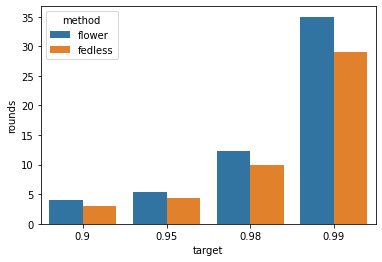

In [5]:
vals = []

for target in [0.9, 0.95, 0.98, 0.99]:
    df_ = flower_df.loc[("mnist", 75, 100, 5)]
    mean_round_until_target_flower = df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean()
    vals.append((target, mean_round_until_target_flower, "flower"))
    df_ = fedless_df.loc["mnist"]
    mean_round_until_target_fedless= df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean() 
    vals.append((target, mean_round_until_target_fedless, "fedless"))
    

df_ = pd.DataFrame(vals, columns=["target", "rounds", "method"])
sns.barplot(x="target", y="rounds", hue="method", data=df_)
df_.pivot(columns="method", values="rounds", index="target")

#### Round Durations

Warm duration differnce mean
          duration
method            
fedless  18.881022
flower   12.084382


Text(0.5, 1.0, 'Fedless Client Durations')

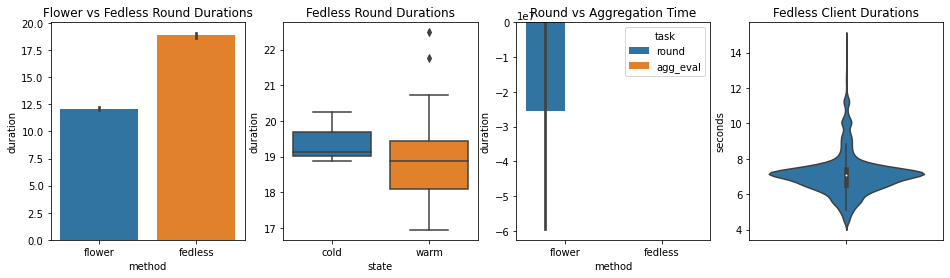

In [6]:
vals = []
detail_vals = []

flwr_df_ = flower_df.loc[("mnist", 75, 100, 5)]
flwr_cold_df_ = flwr_df_[flwr_df_["round"] == 1]
flwr_warm_df_ = flwr_df_[flwr_df_["round"] > 1]
for t in flwr_cold_df_["time"]:
    vals.append(("flower", "cold", "round", t))
for t in flwr_warm_df_["time"]:
    vals.append(("flower", "warm", "round", t))
for t in flwr_warm_df_["time_agg_eval"]:
    vals.append(("flower", "warm", "agg_eval", t))
#for t in flwr_warm_df_["time_clients_fit"]:
#    vals.append(("flower", "warm", "time_clients_fit", t))


fls_df_ = fedless_df.loc["mnist"]
fls_cold_df_ = fls_df_[fls_df_["round"] == 1]
fls_warm_df_ = fls_df_[fls_df_["round"] > 1]
for t in fls_cold_df_["time"]:
    vals.append(("fedless", "cold", "round", t))
for t in fls_warm_df_["time"]:
    vals.append(("fedless", "warm", "round", t))
for t in fls_warm_df_["aggregator_seconds"]:
    vals.append(("fedless", "warm", "agg_eval", t))
#for t in fls_warm_df_["time_clients_fit"]:
#    vals.append(("fedless", "warm", "time_clients_fit", t))
    


df_ = pd.DataFrame(vals, columns=["method", "state", "task", "duration"])
    
fig, axarr = plt.subplots(ncols=4, figsize=(16, 4))

# Warm Durations
df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "round")]
sns.barplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
axarr[0].set_title("Flower vs Fedless Round Durations")

# Cold vs Warm Fedless
df_fedless_ = df_[(df_["method"] == "fedless") & (df_["task"] == "round")]
sns.boxplot(x="state", y="duration", data=df_fedless_, ax=axarr[1])
axarr[1].set_title("Fedless Round Durations")

# Timing Breakdown
sns.barplot(x="method", y="duration", data=df_, ax=axarr[2], hue="task")
axarr[2].set_title("Round vs Aggregation Time")

#df_warm_.groupby(["method", "state"]).mean("duration")
print(f"Warm duration differnce mean")
print(df_warm_.groupby("method").mean())

sns.violinplot(y="seconds", data=fedless_client_df.loc["mnist"], ax=axarr[3])
axarr[3].set_title("Fedless Client Durations")

## FEMNIST

#### Accuracy over Rounds

method,fedless,flower
target,,
0.70,11.5,8.50
0.80,36.5,22.75
0.81,39.0,38.75
0.82,57.5,44.00


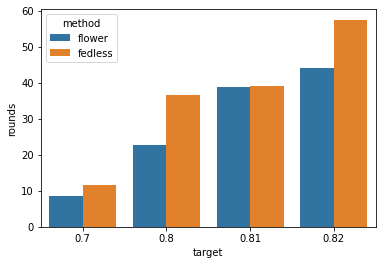

In [7]:
vals = []

for target in [0.7, 0.8, 0.81, 0.82]:
    df_ = flower_df.loc[("femnist", 75, 100, 5)]
    mean_round_until_target_flower = df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean()
    vals.append((target, mean_round_until_target_flower, "flower"))
    df_ = fedless_df.loc["femnist"]
    mean_round_until_target_fedless= df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean() 
    vals.append((target, mean_round_until_target_fedless, "fedless"))
    

df_ = pd.DataFrame(vals, columns=["target", "rounds", "method"])
sns.barplot(x="target", y="rounds", hue="method", data=df_)
df_.pivot(columns="method", values="rounds", index="target")

#### Round Durations

Warm duration differnce mean
          duration  pct-change
method                        
fedless  47.142465         NaN
flower   25.678505     -0.4553


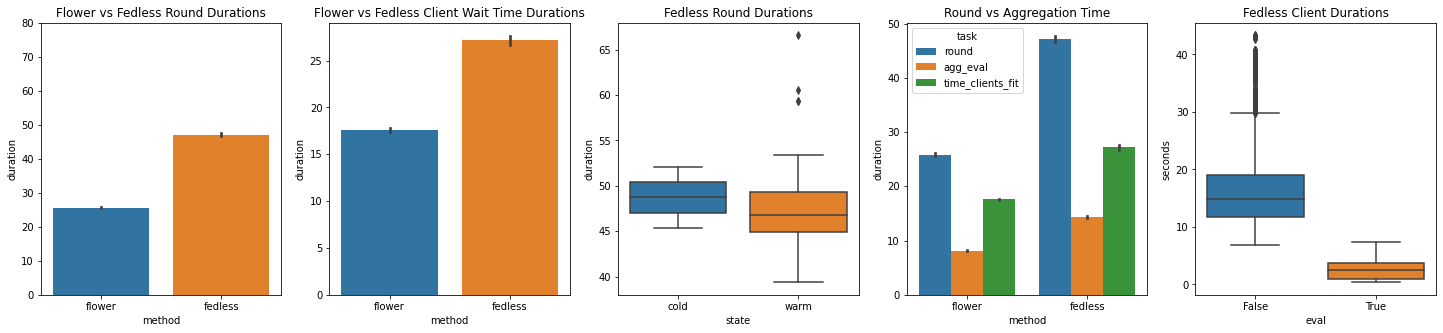

In [8]:
vals = []
detail_vals = []

flwr_df_ = flower_df.loc[("femnist", 75, 100, 5)]
flwr_cold_df_ = flwr_df_[flwr_df_["round"] == 1]
flwr_warm_df_ = flwr_df_[flwr_df_["round"] > 1]
for t in flwr_cold_df_["time"]:
    vals.append(("flower", "cold", "round", t))
for t in flwr_warm_df_["time"]:
    vals.append(("flower", "warm", "round", t))
for t in flwr_warm_df_["time_agg_eval"]:
    vals.append(("flower", "warm", "agg_eval", t))
for t in flwr_warm_df_["time_clients_fit"]:
    vals.append(("flower", "warm", "time_clients_fit", t))


fls_df_ = fedless_df.loc["femnist"]
fls_cold_df_ = fls_df_[fls_df_["round"] == 1]
fls_warm_df_ = fls_df_[fls_df_["round"] > 1]
for t in fls_cold_df_["time"]:
    vals.append(("fedless", "cold", "round", t))
for t in fls_warm_df_["time"]:
    vals.append(("fedless", "warm", "round", t))
for t in fls_warm_df_["aggregator_seconds"]:
    vals.append(("fedless", "warm", "agg_eval", t))
for t in fls_warm_df_["time_clients_fit"]:
    vals.append(("fedless", "warm", "time_clients_fit", t))
    

df_ = pd.DataFrame(vals, columns=["method", "state", "task", "duration"])
    
fig, axarr = plt.subplots(ncols=5, figsize=(25, 5))

# Warm Durations
df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "round")]
sns.barplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
#sns.violinplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
#sns.boxplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
axarr[0].set_ylim(0, 80)
axarr[0].set_title("Flower vs Fedless Round Durations")

df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "time_clients_fit")]
sns.barplot(x="method", y="duration", data=df_warm_, ax=axarr[1])
axarr[1].set_title("Flower vs Fedless Client Wait Time Durations")

# Cold vs Warm Fedless
df_fedless_ = df_[(df_["method"] == "fedless") & (df_["task"] == "round")]
sns.boxplot(x="state", y="duration", data=df_fedless_, ax=axarr[2])
axarr[2].set_title("Fedless Round Durations")

# Timing Breakdown
sns.barplot(x="method", y="duration", data=df_, ax=axarr[3], hue="task")
axarr[3].set_title("Round vs Aggregation Time")


sns.boxplot(x="eval", y="seconds", data=fedless_client_df.loc["femnist"], ax=axarr[4])
axarr[4].set_title("Fedless Client Durations")

#df_warm_.groupby(["method", "state"]).mean("duration")
print(f"Warm duration differnce mean")
df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "round")]
table_df_ = df_warm_.groupby("method").mean()
table_df_["pct-change"] = table_df_.pct_change()
print(table_df_)

## SHAKESPEARE

method,fedless,flower
target,,
0.30,13.0,8.5
0.40,27.0,17.5
0.45,41.0,25.5


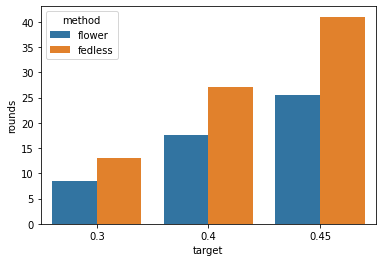

In [9]:
vals = []

for target in [0.3, 0.4, 0.45]:
    df_ = flower_df.loc[("shakespeare", 25, 100, 1)]
    mean_round_until_target_flower = df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean()
    vals.append((target, mean_round_until_target_flower, "flower"))
    df_ = fedless_df.loc["shakespeare"]
    mean_round_until_target_fedless= df_[df_["accuracy"] >= target].groupby("seed").min("round")["round"].mean() 
    vals.append((target, mean_round_until_target_fedless, "fedless"))
    

df_ = pd.DataFrame(vals, columns=["target", "rounds", "method"])
sns.barplot(x="target", y="rounds", hue="method", data=df_)
df_.pivot(columns="method", values="rounds", index="target")

Warm duration differnce mean
            duration  pct-change
method                          
fedless  1148.619022         NaN
flower    262.596205   -0.771381


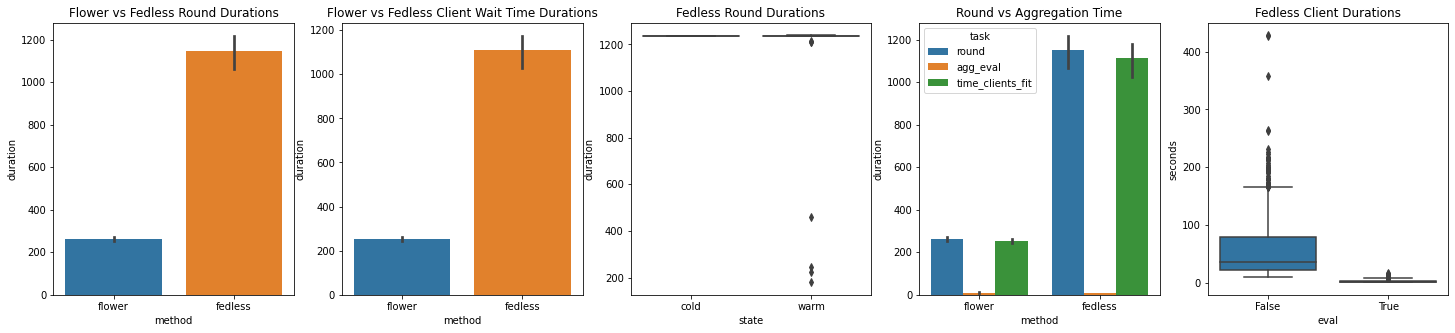

In [10]:
vals = []
detail_vals = []

flwr_df_ = flower_df.loc[("shakespeare", 25, 100, 1)]
flwr_cold_df_ = flwr_df_[flwr_df_["round"] == 1]
flwr_warm_df_ = flwr_df_[flwr_df_["round"] > 1]
for t in flwr_cold_df_["time"]:
    vals.append(("flower", "cold", "round", t))
for t in flwr_warm_df_["time"]:
    vals.append(("flower", "warm", "round", t))
for t in flwr_warm_df_["time_agg_eval"]:
    vals.append(("flower", "warm", "agg_eval", t))
for t in flwr_warm_df_["time_clients_fit"]:
    vals.append(("flower", "warm", "time_clients_fit", t))


fls_df_ = fedless_df.loc["shakespeare"]
fls_cold_df_ = fls_df_[fls_df_["round"] == 1]
fls_warm_df_ = fls_df_[fls_df_["round"] > 1]
for t in fls_cold_df_["time"]:
    vals.append(("fedless", "cold", "round", t))
for t in fls_warm_df_["time"]:
    vals.append(("fedless", "warm", "round", t))
for t in fls_warm_df_["aggregator_seconds"]:
    vals.append(("fedless", "warm", "agg_eval", t))
for t in fls_warm_df_["time_clients_fit"]:
    vals.append(("fedless", "warm", "time_clients_fit", t))
    

df_ = pd.DataFrame(vals, columns=["method", "state", "task", "duration"])
    
fig, axarr = plt.subplots(ncols=5, figsize=(25, 5))

# Warm Durations
df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "round")]
sns.barplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
#sns.violinplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
#sns.boxplot(x="method", y="duration", data=df_warm_, ax=axarr[0])
#axarr[0].set_ylim(0, 80)
axarr[0].set_title("Flower vs Fedless Round Durations")

df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "time_clients_fit")]
sns.barplot(x="method", y="duration", data=df_warm_, ax=axarr[1])
axarr[1].set_title("Flower vs Fedless Client Wait Time Durations")

# Cold vs Warm Fedless
df_fedless_ = df_[(df_["method"] == "fedless") & (df_["task"] == "round")]
sns.boxplot(x="state", y="duration", data=df_fedless_, ax=axarr[2])
axarr[2].set_title("Fedless Round Durations")

# Timing Breakdown
sns.barplot(x="method", y="duration", data=df_, ax=axarr[3], hue="task")
axarr[3].set_title("Round vs Aggregation Time")


sns.boxplot(x="eval", y="seconds", data=fedless_client_df.loc["shakespeare"], ax=axarr[4])
axarr[4].set_title("Fedless Client Durations")

fig.savefig("/Users/andreas/Desktop/shakespeare.pdf")

#sns.lineplot(x="round", y="seconds", data=fedless_client_df.loc["shakespeare"], ax=axarr[4])

#df_warm_.groupby(["method", "state"]).mean("duration")
print(f"Warm duration differnce mean")
df_warm_ = df_[(df_["state"] == "warm") & (df_["task"] == "round")]
table_df_ = df_warm_.groupby("method").mean()
table_df_["pct-change"] = table_df_.pct_change()
print(table_df_)

<AxesSubplot:xlabel='client_id', ylabel='seconds'>

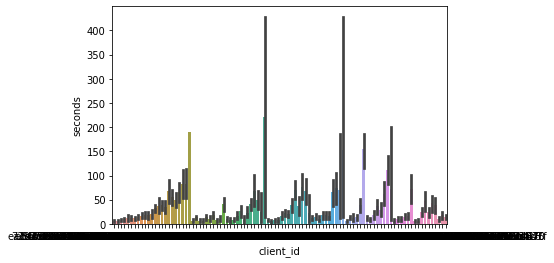

In [11]:
sns.barplot(x="client_id", y="seconds", data=fedless_client_df.loc["shakespeare"])

In [16]:
flwr_df_ = flower_df.loc[("mnist", 75, 100, 5)]
flwr_cold_df_ = flwr_df_[flwr_df_["round"] == 1]
flwr_warm_df_ = flwr_df_[flwr_df_["round"] > 1]
flwr_cold_df_

round      loss                            metrics  \
batch_size seed                                                        
5          1127       1  2.292580  {'accuracy': 0.15929999947547913}   
           11933      1  2.285734   {'accuracy': 0.2556999921798706}   
           15152      1  2.289429  {'accuracy': 0.10740000009536743}   

                  accuracy  time_since_start          time  time_agg_eval  \
batch_size seed                                                             
5          1127     0.1593        125.950208 -1.626027e+09          6.246   
           11933    0.2557        100.248937 -1.626026e+09          6.318   
           15152    0.1074        119.794901 -1.626028e+09          5.987   

                  time_eval  time_clients_fit  
batch_size seed                                
5          1127         NaN               NaN  
           11933        NaN               NaN  
           15152        NaN               NaN